In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

In [2]:
def plot_simplex(ax_3d):
    p1 = np.linspace(-1, 1.1, 221)
    p2 = np.linspace(-1, 1.1, 221)
    P1, P2 = np.meshgrid(p1, p2)
    P3 = 1 - P1 - P2

    mask_simplex = (np.isclose(P1 + P2 + P3, 1) & (P1 >= 0)  & (P2 >= 0)  & (P3 >= 0))
    ax_3d.plot_trisurf(P1[mask_simplex], P2[mask_simplex], P3[mask_simplex], color='k', alpha=0.25)

In [3]:
# https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
# https://matplotlib.org/3.5.0/tutorials/toolkits/mplot3d.html#mpl_toolkits.mplot3d.Axes3D.plot_trisurf

def plot_3d_regions(fited_nn, ax_3d):
    p1 = np.linspace(-1, 1.1, 221)
    p2 = np.linspace(-1, 1.1, 221)
    P1, P2 = np.meshgrid(p1, p2)
    P3 = 1 - P1 - P2

    mask_simplex = (np.isclose(P1 + P2 + P3, 1) & (P1 >= 0)  & (P2 >= 0)  & (P3 >= 0))
    
    P1, P2, P3 = P1[mask_simplex], P2[mask_simplex], P3[mask_simplex]
    
    _, ind = fited_nn.kneighbors(np.vstack([np.ravel(P1), np.ravel(P2), np.ravel(P3)]).T)
    
    mask0, mask1, mask2 = ind[:, 0] == 0, ind[:, 0] == 1, ind[:, 0] == 2
    
    for mask_, c in zip([mask0, mask1, mask2], ['r', 'b', 'g']):
        ax_3d.plot_trisurf(P1[mask_], P2[mask_], P3[mask_], color=c, alpha=0.25)

In [4]:
def config_ax(ax):
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    
    ax.tick_params(axis='both', which='major', pad=-4)
    ticks = np.linspace(0, 1, 5)
    ticks_str = list(map(lambda x: str(x) if x not in [0, 1] else str(int(x)), np.linspace(0, 1, 5)))
    fontsize = 6
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks_str, fontsize=fontsize)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks_str, fontsize=fontsize)
    ax.set_zticks(ticks)
    ax.set_zticklabels(['0', '', '', '', '1'], fontsize=fontsize)
    
    ax.set_xlabel('Class 0 prob', labelpad=-8)
    ax.set_ylabel('Class 1 prob', labelpad=-8)
    ax.set_zlabel('Class 2 prob', labelpad=-12)
    
    ax.view_init(elev=45, azim=45, roll=0)
    
    return ax

In [5]:
# make_classification(n_samples=1000, n_informative=6, n_classes=3, weights=(0.5, 0.4, 0.1), random_state=42)

from sklearn.datasets import fetch_openml

def make_n_classes(n, y):
    dic = dict(zip(y.value_counts().head(n-1).index,range(n-1)))
    return np.array(list(map(lambda x: dic.get(x, n-1), y)))

def read_dataset():
    X, y_original = fetch_openml(
        data_id=4541, parser='auto', return_X_y=True, as_frame=True
    )
    y = make_n_classes(3, y_original)
    X = X.drop(columns=['encounter_id', 'patient_nbr'])
    return X, y

___

inicio

In [6]:
X, y = read_dataset()

X_train_model, X_test, y_train_model, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train_model, X_train_threshold, y_train_model, y_train_threshold = \
train_test_split(X_train_model, y_train_model, test_size=0.2, random_state=0, stratify=y_train_model)

Em um problema de classificação multiclasse (com n classes), o output de um típico classificador do scikit-learn será um vetor com `.shape` `(n_samples, n)`. Para cada exemplo esse vetor de `n` componentes me conta a probabilidade daquele exemplo pertencer a classe associada a cada índice, ou seja, a primeira componente é a probabilidade da primeira classe, a segunda componente da segunda classe e assim por diante.

No caso de classificação binária isso também ocorre, e é por isso que costumamos trabalhar apenas com a segunda componente desse vetor selecionando `probs[:, 1]`.

In [7]:
model = LGBMClassifier(random_state=42).fit(X_train_model, y_train_model)

probs = model.predict_proba(X_train_threshold)
preds = model.predict(X_train_threshold)

print(f"Number of samples in X_train_threshold: {X_train_threshold.shape[0]}.",
      f"Number of classes: {len(np.unique(y))}.",
      f"\nprobs.shape: {probs.shape}.")

Number of samples in X_train_threshold: 15265. Number of classes: 3. 
probs.shape: (15265, 3).


Como o predict é definido como o argmax tal, então o predict é equivalente a achar qual vértice é o mais próximo do .predict_proba.

In [37]:
centers = np.identity(3)

nn = NearestNeighbors(n_neighbors=1, p=2).fit(centers)

_, ind = nn.kneighbors(probs)
(ind[:, 0] == preds).all()

True

In [9]:
color_dic = dict(zip(range(3), ['r', 'b', 'g']))

In [45]:
plot_sample = np.random.RandomState(42).choice(len(probs), 1000, replace=False)

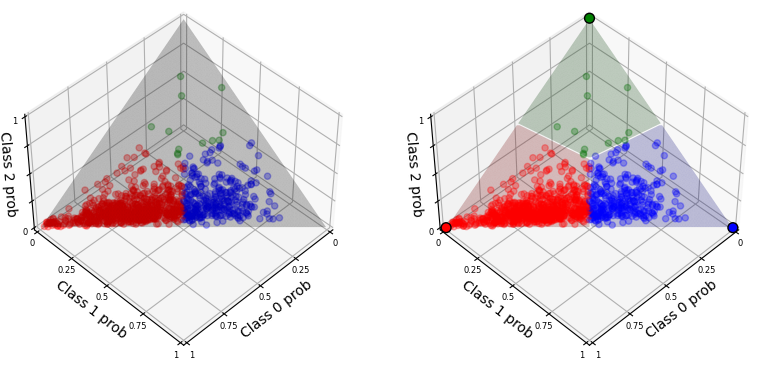

In [48]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')

for axis in ax:
    config_ax(axis)

color_list_preds = list(map(lambda x: color_dic[x], preds[plot_sample]))
ax[0].scatter(probs[plot_sample, 0], probs[plot_sample, 1], zs=probs[plot_sample, 2], c=color_list_preds, alpha=0.3)
plot_simplex(ax[0])

color_list_nn = list(map(lambda x: color_dic[x], ind[plot_sample, 0]))
ax[1].scatter(probs[plot_sample, 0], probs[plot_sample, 1], zs=probs[plot_sample, 2], c=color_list_nn, alpha=0.3)
ax[1].scatter(centers[:, 0], centers[:, 1], zs=centers[:, 2], c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1)
plot_3d_regions(nn, ax[1])

plt.show()

Isso nos motiva a encontrar outras formas de definir o predict_proba que podem ser relevantes tais quais sabemos ser o caso em problemas desbalanceados binários!

Porque não mover os pontos dos quais dizemos que eles serão os mais proximos?

Se sorteamos pontos aleatórios temos....


In [12]:
def runif_in_simplex(n, d=3, random_state=None):
    ''' Return n uniformly random vector in the d-simplex '''
    # https://stackoverflow.com/questions/65154622/sample-uniformly-at-random-from-a-simplex-in-python
    k = np.random.RandomState(random_state).exponential(scale=1.0, size=(d, n))
    return np.divide(k, k.sum(axis=0)).T

In [13]:
centroides_candidates = runif_in_simplex(3, random_state=10)
centroides_candidates

array([[0.47939814, 0.44888388, 0.07171798],
       [0.00979707, 0.32243709, 0.66776584],
       [0.69537845, 0.17633038, 0.12829117]])

Esses novos pontos definem diagramas de influência (Voronoi) diferentes dos iniciais em que os centroides eram os do tipo `centroides_candidates = np.identity(3)`.

In [14]:
nn_candidates = NearestNeighbors(n_neighbors=1, p=2).fit(centroides_candidates)

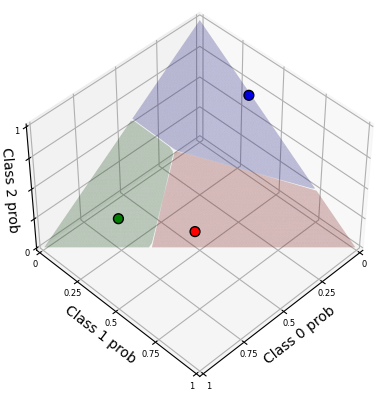

In [15]:
ax = plt.figure().add_subplot(projection='3d')

config_ax(ax)
ax.scatter(centroides_candidates[:, 0], centroides_candidates[:, 1], zs=centroides_candidates[:, 2], c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1)
plot_3d_regions(nn_candidates, ax)
plt.show()

Problemas...
 pode ter caso que um mesmo cara fica na borda de mais de um
 
 e pode acontecer de trocar as edges...

In [16]:
def sample_valid_point(n, random_state=None):
    sample = runif_in_simplex(n, random_state=random_state)
    edges = np.identity(n)
    nn_sample = NearestNeighbors(n_neighbors=1, p=2).fit(sample)
    _, ind_edges = nn_sample.kneighbors(edges)
    
    if len(np.unique(ind_edges[:, 0])) == 3:
        return sample[ind_edges[:, 0]] # ordena do jeito certo
    else:
        new_random_state = np.random.RandomState(random_state).randint(0, 2**32 - 1, dtype=np.int64)
        return sample_valid_point(n, random_state=new_random_state)

In [17]:
from sklearn.metrics import f1_score

macro < micro rs 
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [18]:
macro_f1s = []

for i in tqdm(range(10000)):
    centroides = sample_valid_point(3, random_state=i)
    nn_centroides = NearestNeighbors(n_neighbors=1, p=2).fit(centroides)
    _, new_preds = nn_centroides.kneighbors(probs)
    macro_f1s.append(f1_score(y_train_threshold, new_preds[:, 0], average='macro'))

100%|██████████| 10000/10000 [04:15<00:00, 39.19it/s]


In [19]:
np.max(macro_f1s)

0.45220096685015615

In [20]:
f1_score(y_train_threshold, preds, average='macro')

0.4101219818822821

In [21]:
best_random_state = np.argmax(macro_f1s)

In [22]:
centroides = sample_valid_point(3, random_state=best_random_state)
nn_centroides = NearestNeighbors(n_neighbors=1, p=2).fit(centroides)

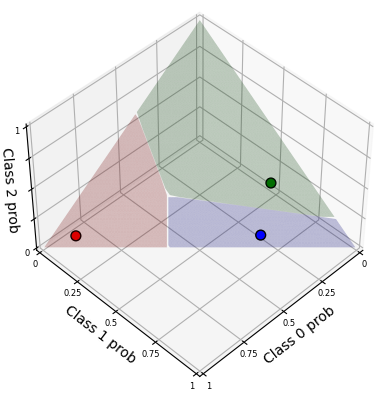

In [23]:
ax = plt.figure().add_subplot(projection='3d')

config_ax(ax)
ax.scatter(centroides[:, 0], centroides[:, 1], zs=centroides[:, 2], c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1)
plot_3d_regions(nn_centroides, ax)
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

In [25]:
for i in range(3):
    print(i, roc_auc_score(1*(y_test==i), model.predict_proba(X_test)[:, i]))

0 0.7011721154461696
1 0.6657299235133072
2 0.6532386195855607


In [26]:
_, a = nn_centroides.kneighbors(model.predict_proba(X_test))

In [27]:
f1_score(y_test, model.predict(X_test), average='macro')

0.4153827179318625

In [28]:
f1_score(y_test, a, average='macro')

0.46007371987175505

___

___

discuto outras métricas? ...

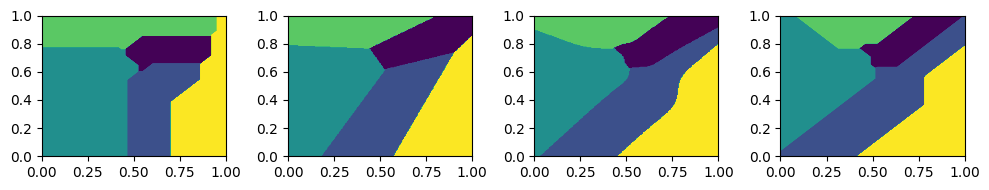

In [29]:
centros = np.random.RandomState(0).uniform(0, 1, size=(5, 2))
x=np.linspace(0, 1, 201)
y=np.linspace(0, 1, 201)
 
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(ncols=4, figsize=(10, 2))

for i, p in enumerate([1, 2, 4, 50]):
    nn = NearestNeighbors(n_neighbors=1, p=p).fit(centros)

    _, ind = nn.kneighbors(np.vstack([np.ravel(X), np.ravel(Y)]).T)
    Z = ind.reshape(X.shape)

    ax[i].contourf(X, Y, Z, 100)

plt.tight_layout()

___

Vale fazer um for pra mais classes assim mostrando os ganhos de F1.

In [30]:
# from sklearn.ensemble import RandomForestClassifier

In [31]:
# for N_FEATURES in tqdm(range(2, 11)):
#     X, y = make_classification(n_samples=1000, n_features=30, n_informative=22, n_classes=N_FEATURES, random_state=42)

#     model = RandomForestClassifier(max_depth=5, random_state=42).fit(X, y)

#     probs = model.predict_proba(X)
#     preds = model.predict(X)

#     centers = np.identity(N_FEATURES)

#     nn = NearestNeighbors(n_neighbors=1).fit(centers)

#     _, ind = nn.kneighbors(probs)
#     assert (ind[:, 0] == preds).all()

___